# Reconocimiento de placas.
Este codigo fue escrito por Christian Mateo Benitez Rojas.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Funciones a utilizar.

In [2]:
# Funcion para crear la mascara de una imagen deacuerdo a la intencidad de color.
# img: imagen que se va a sacar la mascara.
# lower: recibe un [], con las intencidades bajas de cada canal.
# upper: recibe un [], con intencidades altas de cada canal.
def image_segmentation(img, lower, upper):
  row = img.shape[0]
  column = img.shape[1]

  mask = np.zeros([row, column], dtype='uint8')
  for i in range(row):
    for j in range(column):
      if lower[0] < img[i,j,0] < upper[0] and \
         lower[1] < img[i,j,1] < upper[1] and \
         lower[2] < img[i,j,2] < upper[2] :
        mask[i,j] = 255
      else:
        mask[i,j] = 0
  return mask

In [3]:
# Funcion que imprime un histograma de colores por cada canal.
# chop: el pedazo de imagen que se desea analizar la intencidad.
def color_histogram(chop):
  axe = plt.subplots(3,1, figsize=(17,5))[1]
  for i in range(3):
    hist = cv2.calcHist([chop],[i], None,[255],[0,255])
    axe[i].plot(hist)
    axe[i].set_xticks(range(0,255,10))

In [4]:
# Funcion que...
def prepare_image(img, lower, upper, ker=(19,19)):
    # Segmentando imagen teniendo en cuenta las intencidades de los canales.
    mask = image_segmentation(img, lower, upper)

    # Rellenando imagen.
    kernel = np.ones(ker,np.uint8)
    cierre = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Sacamos contornos.
    # Buscar contornos en la imagen binarizada.
    contours, _ = cv2.findContours(cierre, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    numbers_letters = []
    # Recorrer los contornos encontrados
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        number = cierre[y:y+h, x:x+w]
        # Se va a aplicar a cada image...
        number = cv2.resize(number, [75, 150]) # Imagen de 75*150
        number = cv2.threshold(number, 125, 255, cv2.THRESH_BINARY)[1] # Binarización con umbral de 125.
        number = number / 255
        numbers_letters.append(number)
    return cierre, numbers_letters

In [96]:
# Función que imprime todos los contornos resultantes de un array de contornos.
# contours_array: Un array de contornos.
# size: El tamaño de el plot columnasxfilas: Default: (3, 6)
def plot_all(contours_array, size=(3,6)):
    axe = plt.subplots(size[0], size[1])[1]
    axe = axe.flatten()
    for i, chop in enumerate(contours_array):
        axe[i].imshow(chop, cmap='gray')
        axe[i].set_xticks([])
        axe[i].set_yticks([])

In [94]:
# Funcion que aplana los contornos encontrados de una imagen y los almacena en un array.
# contours: un array de contornos de una imagen.
# array_targets: un array que contiene los targets de los contornos consecutivamente. Si un contorno no se desea etiquietar se pone None.
# array_result: array donde se almacena los resultados.
# resize: tamaño de la imagen aplanada. Default: 75*150. 
def extract(contours, array_targets, array_result, resize=[75*150]):
    for i, target in enumerate(array_targets):
        if(target != None):
            img_resized = contours[i].reshape(resize)
            array_result.extend([target, img_resized])
    return array_result

In [92]:
# Funcion que reajusta la perspectiva de una imagen, teniendo en cuenta cuatro puntos de corte.
# image: Recibe la imagen que se desea ajustar.
# po: un array de arrays que contienen la posicion de los puntos.
# width: ancho de la imagen resultado. Default: 750px.
# height: alto de la imagen resultado. Default: 300px.
def adjust_perspective(image, po, mask_width=700, mask_height=200):
    points = np.float32(po)
    mapping = np.float32([[0,0], [mask_width, 0], [0, mask_height], [mask_width, mask_height]])
    perspective = cv2.getPerspectiveTransform(points, mapping)
    image_perspective = cv2.warpPerspective(image, perspective, (mask_width, mask_height))
    return image_perspective

In [97]:
# Estas funciones son utilizadas para transformar la placa ya cortada y procesada a una base de datos de pandas.


# Funcion que saca los contornos de una imagen ya preparada en blanco y negro y umbralizada.
# imagen_thresh: Es una imagen binarizada y en blanco y negro.
def get_contours(imagen_thresh):
    # Buscar contornos en la imagen binarizada.
    contours = cv2.findContours(imagen_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    numbers = []
    # Recorrer los contornos encontrados y aplicamos...
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        number = imagen_thresh[y:y+h, x:x+w]
        # Se va a aplicar a cada contorno...
        number = cv2.resize(number, [75, 150]) # Cambio de tamaño 75x150
        number = cv2.threshold(number, 125, 255, cv2.THRESH_BINARY)[1] # Binarización con umbral de 125.
        number = number / 255 # Normalizando.
        numbers.append(number)
    return numbers

# Funcion que convierte los contornos de una imagen a un dataframe de pandas.
# contours: Array que contiene los contornos de una imagen.
def flatten_contours(contours):
    letters_flatten = []
    # Ciclo que recorre cada contorno.
    for contour in contours:
        letters_flatten.append(contour.reshape(75*150))
    letters_flatten = pd.DataFrame(letters_flatten)
    return letters_flatten

# Funcion que procesa la placa del lado izquierdo y el derecho. La imagen debe estar bien binarizada y recortada.
# image_letters: El lado izquierdo de las letras de la placa.
# image_numbers: El lado derecho de los numeros de la placa.
def proccess_plate(image_letters, image_numbers):
    contours_letters = get_contours(image_letters)
    contours_numbers = get_contours(image_numbers)
    contours_letters_flatten = flatten_contours(contours_letters)
    contours_numbers_flatten = flatten_contours(contours_numbers)
    return contours_letters_flatten, contours_numbers_flatten 

# Segmentando imagenes y preparando base de datos.
A continuación se mostrará como se procesaron cada una de las imagenes.

In [7]:
# Dirección local de donde están las imagenes para entrenar.
plates_dir = '/home/christian/universidad/Redes neuronales/reconocimiento_placas/Trabajo Placas/Entrenamiento'
plates = os.listdir(plates_dir)

Las imagemes se cargaron en formato HSV para tener mas precisión a la hora de segmentar. 

(2534, 2916, 3)

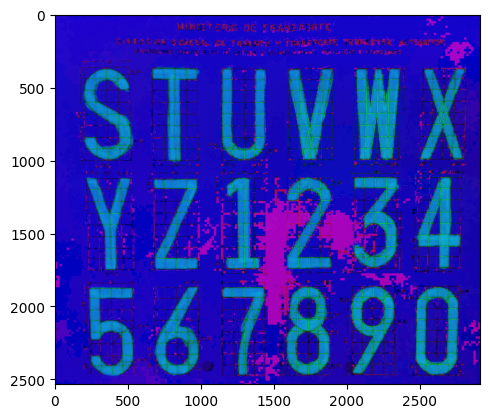

In [8]:
img = cv2.imread(plates_dir + '/' + plates[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(img)
img.shape

A cada imagen se extrajo un pedazo de las letras para analizar las intencidades de los colores

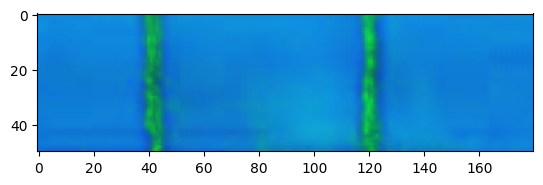

In [9]:
chop = img[390:440, 700:880, :]
plt.imshow(chop)

Aquí podemos ver el histograma de colores representando la antidad de pixeles por intencidad. 
Cada grafica corresponde a los canales H S V

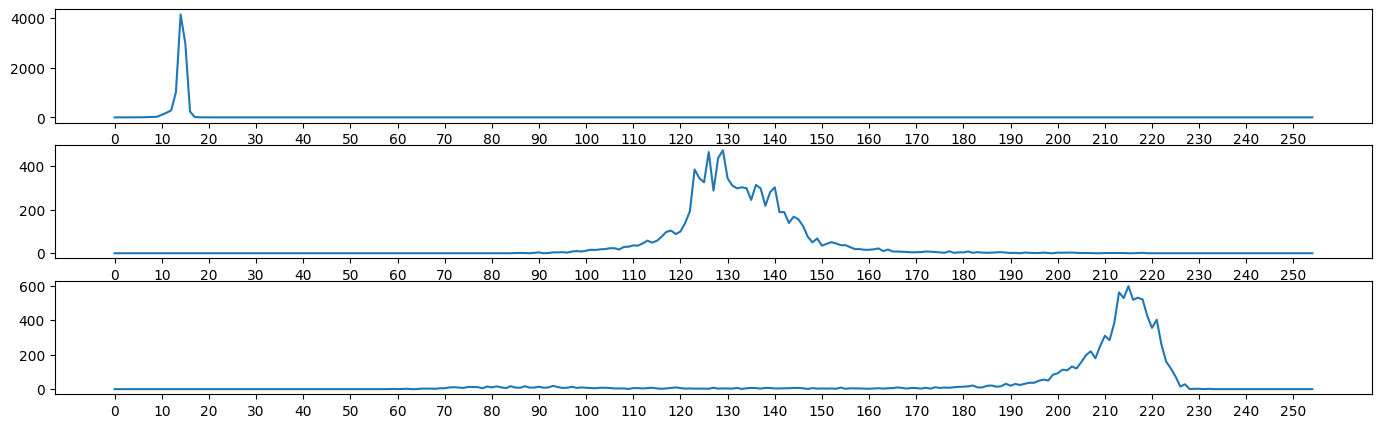

In [10]:
color_histogram(chop)

Ya teniendo en cuenta la anterior información, procedemos a segmentar teniendo en cuenta esas intencidades por cada canal.

In [11]:
lower = [10, 90, 65]
upper = [17, 200, 229]

mask = image_segmentation(img, lower, upper)
result = cv2.bitwise_and(img, img, mask=mask)

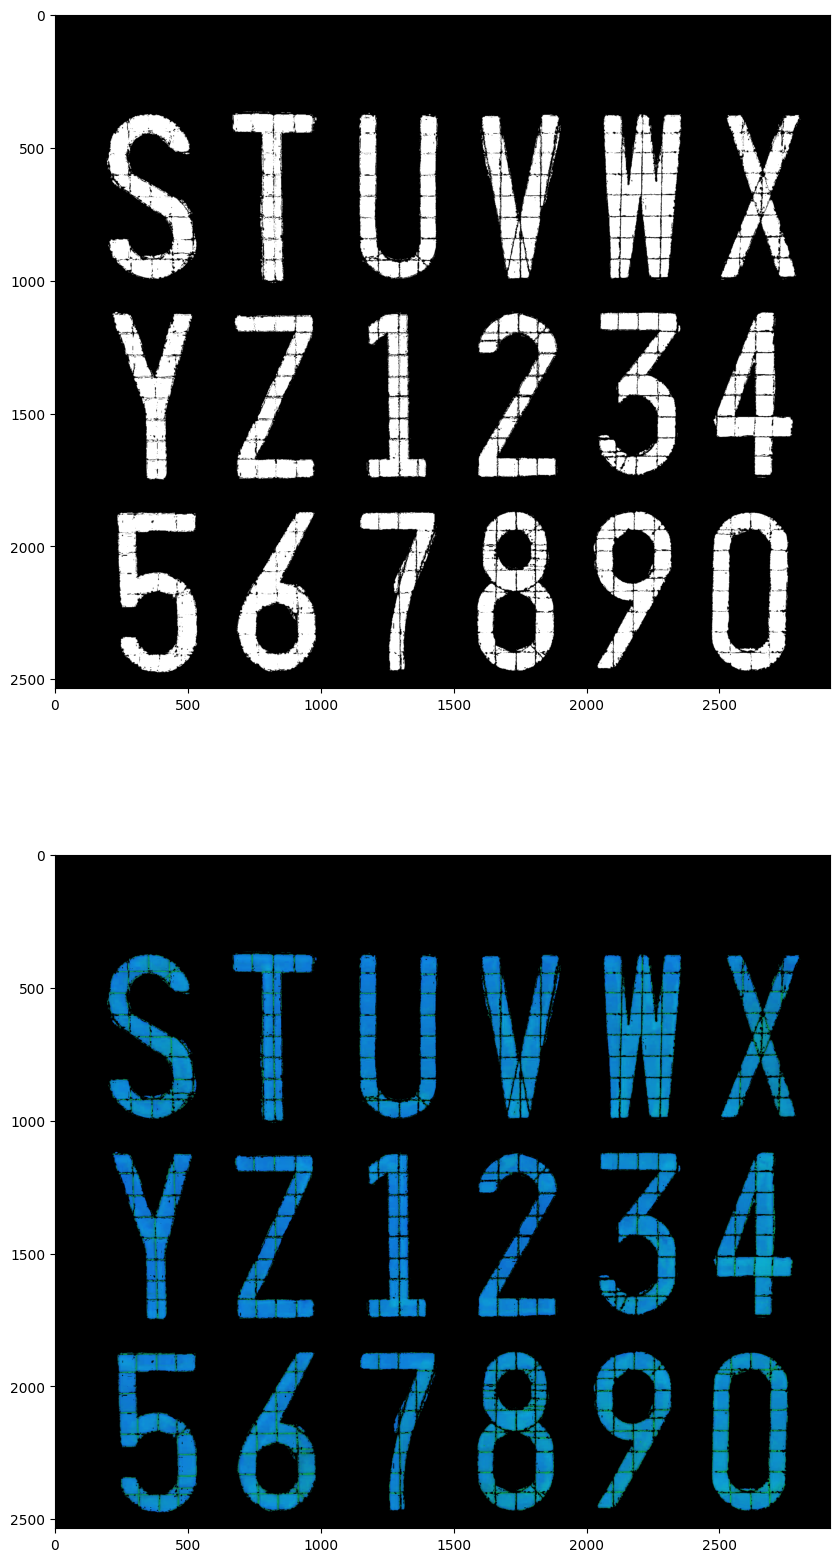

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20))
ax[0].imshow(mask, cmap='gray')
ax[1].imshow(result)

Ahora apliqué un algoritmo morfologico de cierre para completar la figura.

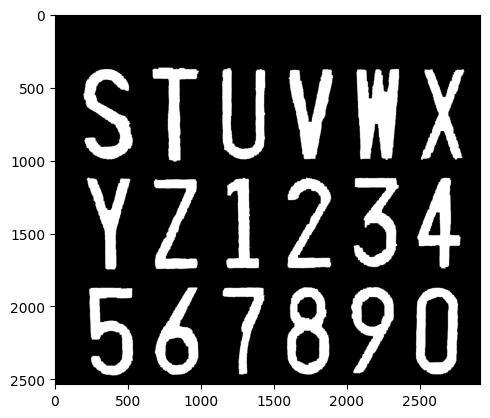

In [13]:
# Cierre.
kernel = np.ones((19,19),np.uint8)
cierre = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
plt.imshow(cierre, cmap='gray')

Ahora para finalizar se extrajeron los contornos de las imagenes, se recortaron y se modificaron cada corte a un tamaño de 300x600 

In [14]:
# Buscar contornos en la imagen binarizada
contours, _ = cv2.findContours(cierre, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

numbers_letters = []
# Recorrer los contornos encontrados
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    number = cierre[y:y+h, x:x+w]
    number = cv2.resize(number, [300, 600])
    numbers_letters.append(number)

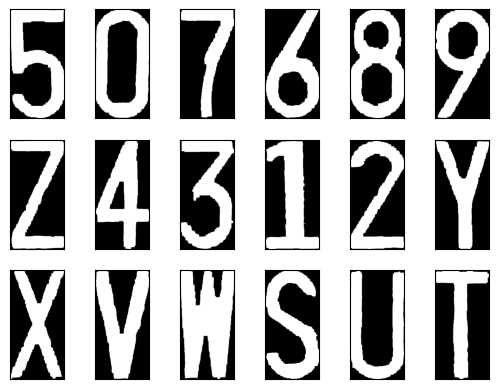

In [15]:
axe = plt.subplots(3, 6)[1]
axe = axe.flatten()
for i, chop in enumerate(numbers_letters):
    axe[i].imshow(chop, cmap='gray')
    axe[i].set_xticks([])
    axe[i].set_yticks([])

# Procesando todas las imagenes.
Para cada imagen se aplicaron las mismas reglas anteriormente. Se utilizaron funciones con el fin de reutilizar e código.

Procesando imagen 1

In [16]:
lower = [10, 90, 65]
upper = [17, 200, 229]
figure1, numbers_n_letters1 = prepare_image(img, lower, upper)

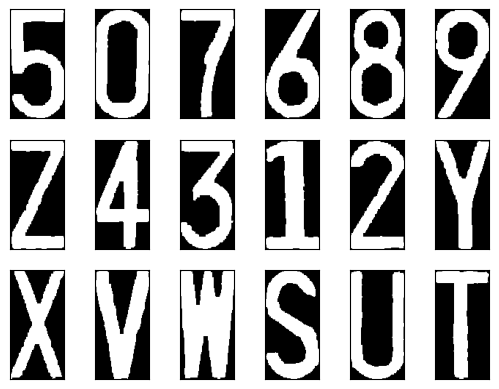

In [17]:
plot_all(numbers_n_letters1)

In [18]:
db_numbers = []
db_letters = []

Extrayendo las letras y los numeros imagen 1

In [19]:
# Extrayendo los numeros a base de datos.
numbers_target = [5, 0, 7, 6 , 8, 9, None, 4, 3, 1, 2]
db_numbers = extract(contours=numbers_n_letters1, array_targets=numbers_target, array_result=db_numbers)

In [20]:
# Extrayendo las letras a la base de datos.
letters_target = [None, None, None, None, None, None, 25, None, None, None, None, 24, 23, 21, 22, 18, 20, 19]
db_letters = extract(numbers_n_letters1, letters_target, db_letters)

Procesando imagen 2

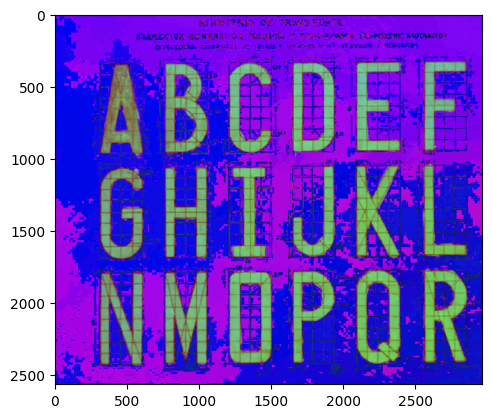

In [21]:
path_img2 = plates_dir + '/' + plates[1]
img2 = cv2.imread(path_img2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
plt.imshow(img2)

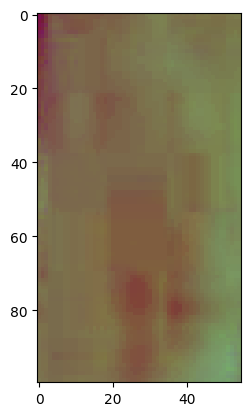

In [22]:
# Porcion de una letra para segmentar.
chop = img2[650:750, 365:420, :]
plt.imshow(chop)

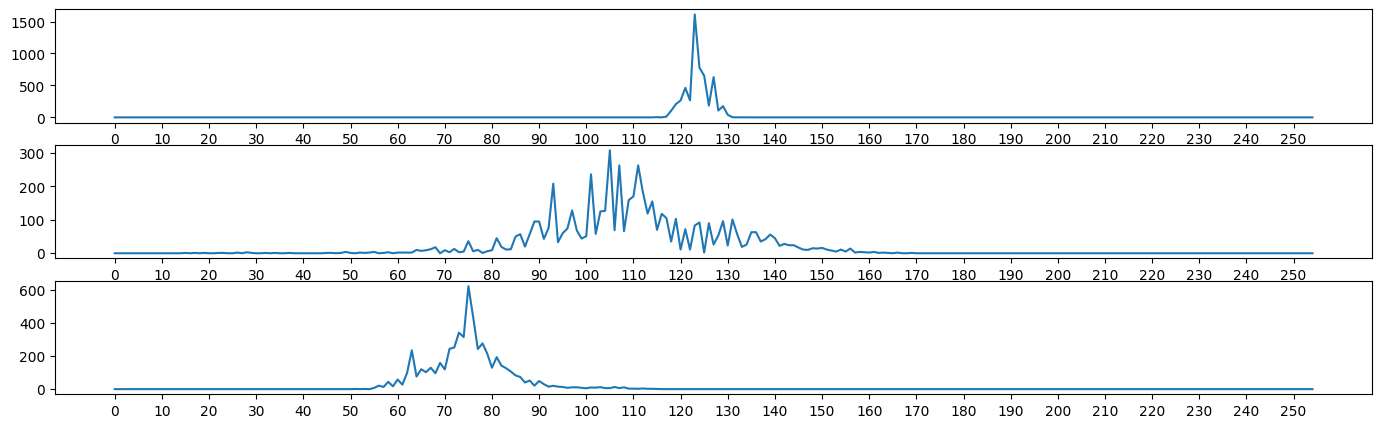

In [23]:
color_histogram(chop)

In [24]:
# Segmentando teniendo en cuenta el histograma de color.
figure2, numbers_n_letters2 = prepare_image(img2, lower=[111, 50, 54], upper=[131, 211, 180])

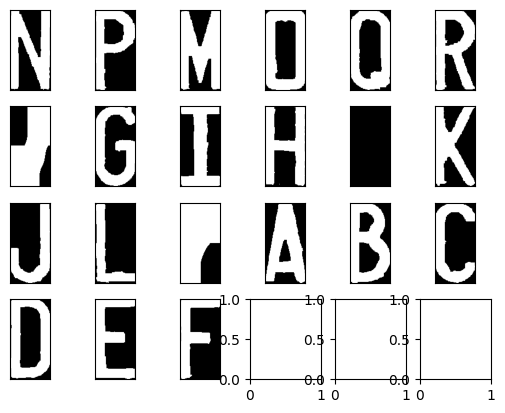

In [25]:
plot_all(numbers_n_letters2, size=(4, 6))

In [26]:
# Extrayendo las letras a una base de datos.
letters_target = [12, 15, 13, 14, 16, 17, None, 6, 8, 7, None, 10, 9, 11, None, 0, 1, 2, 3, 4, 5]
db_letters = extract(numbers_n_letters2, letters_target, db_letters)

Procesando imagen 3

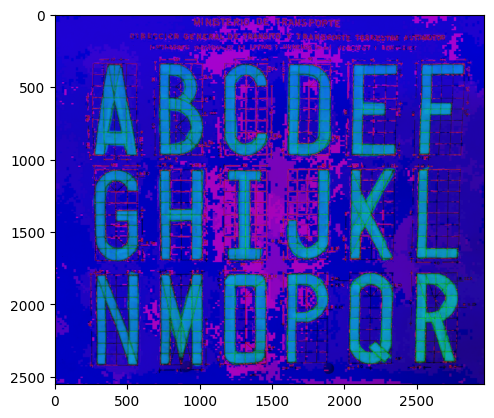

In [27]:
path_img3 = plates_dir + '/' + plates[5]
img3 = cv2.imread(path_img3)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2HSV)
plt.imshow(img3)

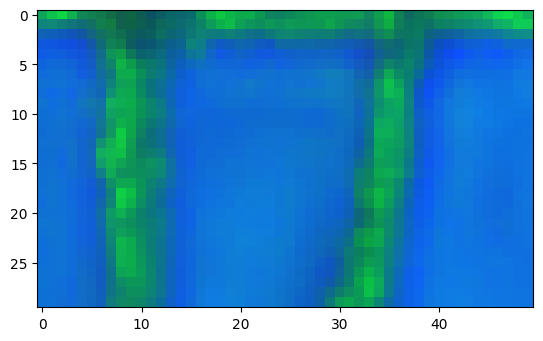

In [28]:
# Porcionando partes del color que quiero segmentar.
chop = img3[420:450, 400:450, :]
plt.imshow(chop)

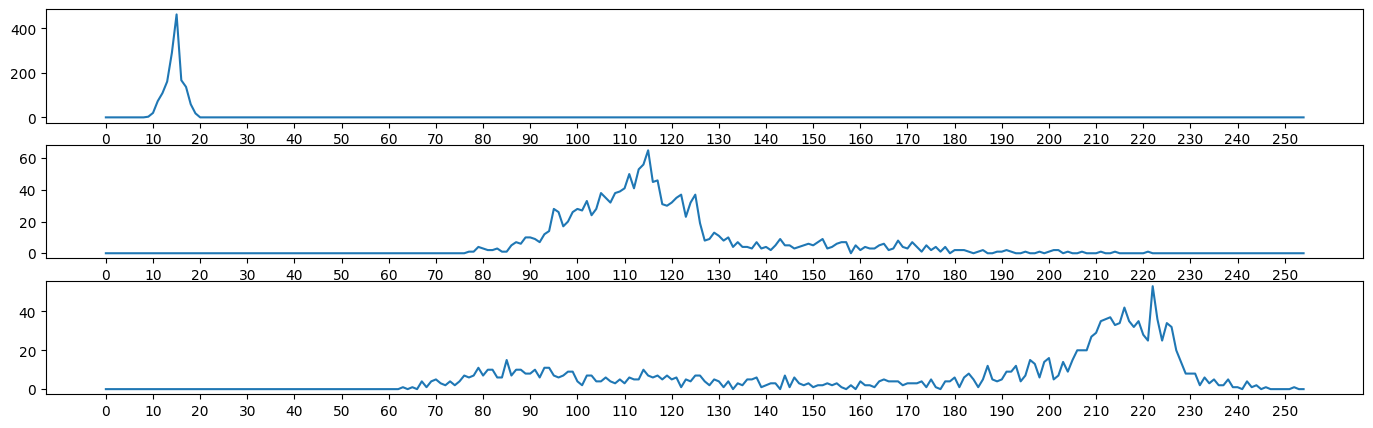

In [29]:
color_histogram(chop)

In [30]:
# Segmentando la imagen teniendo en cuenta el histograma de color por cada canal hsv.
figure3, numbers_n_letters3 = prepare_image(img3, lower=[10, 77, 62], upper=[20, 220, 246])

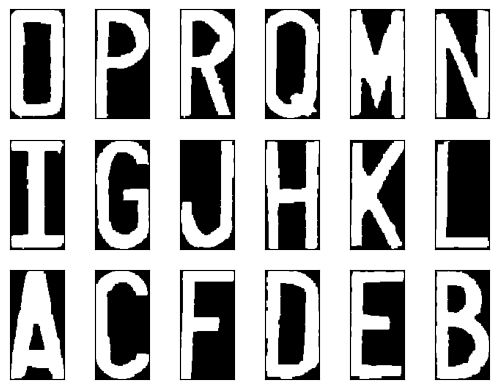

In [31]:
# Resultado de la segmentacion y del corte.
plot_all(numbers_n_letters3)

In [32]:
# Extrayendo las letras a la base de datos.
letters_target = [14, 15, 17, 16, 13, 12, 8, 6, 9, 7, 10, 11, 0, 2, 5, 3, 4, 1]
db_letters = extract(numbers_n_letters3, letters_target, db_letters)

Procesando imagen 4

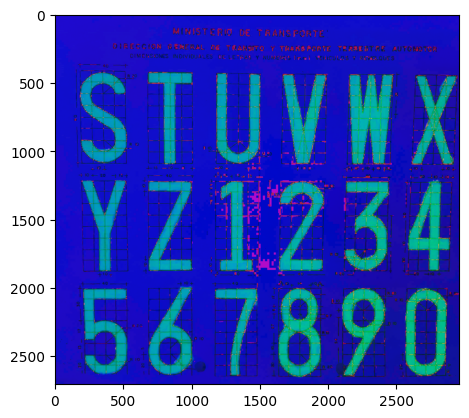

In [33]:
path_img4 = plates_dir + '/' + plates[3]
img4 = cv2.imread(path_img4)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2HSV)
plt.imshow(img4)

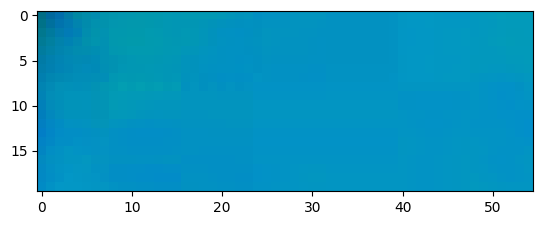

In [34]:
chop = img4[520:540, 200:255, :]
plt.imshow(chop)

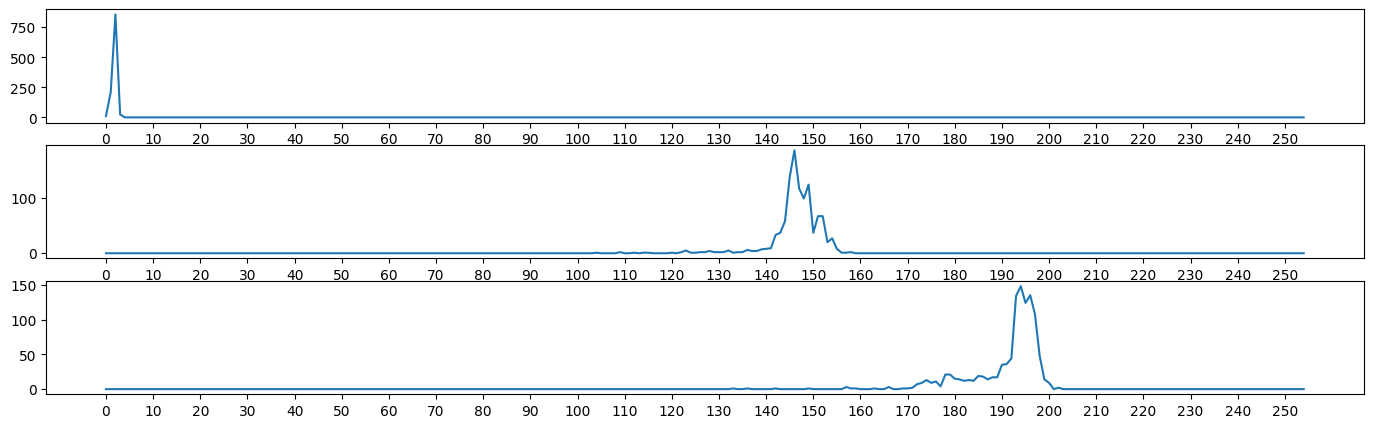

In [35]:
color_histogram(chop)

In [36]:
figure4, numbers_n_letters4 = prepare_image(img4, [0, 125, 55], [5, 220, 200])

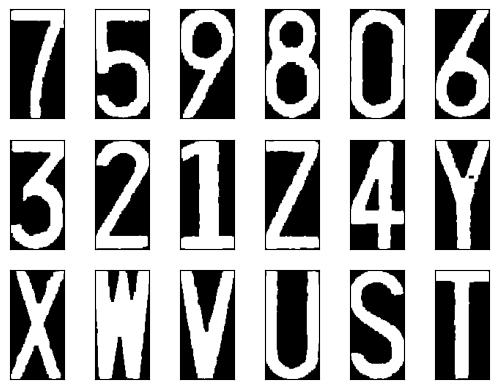

In [37]:
# Resultado de la segmentacion y del corte.
plot_all(numbers_n_letters4)

In [38]:
numbers_target = [7, 5, 9, 8, 0, 6, 3, 2, 1, None, 4]
letters_target = [None, None, None, None, None, None, None, None, None, 25, None, 24, 23, 22, 21, 20, 18, 19]
db_numbers = extract(numbers_n_letters4, numbers_target, db_numbers)
db_letters = extract(numbers_n_letters4, letters_target, db_letters)

Creando las bases de datos en CSV

In [39]:
images_targets_numbers = db_numbers[0::2]
images_flatten_numbers = pd.DataFrame(db_numbers[1::2])

# Agrega los targets al final de la base de datos.
images_flatten_numbers['target'] = images_targets_numbers

In [40]:
images_targets_letters = db_letters[0::2]
images_flatten_letters = pd.DataFrame(db_letters[1::2])

# Agrega los targets al final de la base de datos.
images_flatten_letters['target'] = images_targets_letters

In [41]:
# Guardando en mi ordenador en formato csv.
np.savetxt("db_numbers.csv", images_flatten_numbers, delimiter=",")
np.savetxt("db_letters.csv", images_flatten_letters, delimiter=",")

# Creando la red neuronal
Antes de entregar los datos a la red, es necesario binarizar y normalizar las imagenes.

In [98]:
# Librerias para construir la red.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [99]:
# Cargando bases de datos anteriormente creadas.
ndb = pd.read_csv('./db_numbers.csv', header=None) # numbers data base
ldb = pd.read_csv('./db_letters.csv', header=None) # letters data base

Red neuronal de los numeros.

Preparando targets.

In [100]:
number_targets = ndb.pop(11250) # la ultima columna es el target.

In [101]:
number_targets = to_categorical(number_targets, num_classes=10)
number_targets

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [180]:
number_targets.shape

(20, 10)

In [181]:
ndb.shape

(20, 11251)

In [102]:
# Artificial neuronal network (ann).
# Creando red neuronal con keras de tensorflow.
ann_numbers = Sequential()
ann_numbers.add(Dense(200, input_shape = (75*150,), activation = 'tanh'))
ann_numbers.add(Dense(150, activation = 'tanh'))
ann_numbers.add(Dense(10, activation = 'softmax'))

# Configurando red neuronal.
ann_numbers.compile(loss = 'mae', metrics = ['accuracy'])

# optimizer = 'adam'
# mean absolute error (mae). Se utiliza para medir la diferencia entre las predicciones del modelo y los valores reales de la variable objetivo en el conjunto de datos de entrenamiento.
# Optimizer adam. Ajustar los parámetros del modelo de manera eficiente y efectiva para minimizar la función de pérdida.
# Softmax. utilizada en la última capa de una red neuronal para problemas de clasificación multiclase.

2023-05-25 13:49:02.422425: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [103]:
ann_numbers.fit(ndb, number_targets, epochs = 50, batch_size = 100 , verbose = 1, validation_split = 0.1)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.1796 - accuracy: 0.2222 - val_loss: 0.1903 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 101ms/step - loss: 0.1150 - accuracy: 0.5556 - val_loss: 0.1446 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 92ms/step - loss: 0.1237 - accuracy: 0.5556 - val_loss: 0.1039 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 91ms/step - loss: 0.1159 - accuracy: 0.3889 - val_loss: 0.0443 - val_accuracy: 1.0000
Epoch 5/50
1/1 [==============================] - 0s 88ms/step - loss: 0.1069 - accuracy: 0.4444 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 6/50
1/1 [==============================] - 0s 85ms/step - loss: 0.0891 - accuracy: 0.5556 - val_loss: 0.0394 - val_accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - 0s 83ms/step - loss: 0.0516 - accuracy: 0.8889 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 8/50
1/1 [========

Red neuronal de letras.

Preparando targets.

In [104]:
target_letters = ldb.pop(11250)
target_letters = to_categorical(target_letters, num_classes=26)

In [243]:
target_letters.shape

(52, 26)

In [183]:
ldb.shape

(52, 11250)

In [105]:
# Artificial neuronal network (ann).
# Creando red neuronal con keras de tensorflow.
ann_letters = Sequential()
ann_letters.add(Dense(200, input_shape = (150*75,), activation = 'tanh'))
ann_letters.add(Dense(150, activation = 'tanh'))
ann_letters.add(Dense(26, activation = 'softmax'))

# Configurando red neuronal.
ann_letters.compile(loss = 'mae', metrics = ['accuracy'])

# optimizer = 'adam'
# mean absolute error (mae). Se utiliza para medir la diferencia entre las predicciones del modelo y los valores reales de la variable objetivo en el conjunto de datos de entrenamiento.
# Optimizer adam. Ajustar los parámetros del modelo de manera eficiente y efectiva para minimizar la función de pérdida.
# Softmax. utilizada en la última capa de una red neuronal para problemas de clasificación multiclase.

In [106]:
ann_letters.fit(ldb, target_letters, epochs = 50, batch_size = 50 , verbose = 1, validation_split = 0.1)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.0741 - accuracy: 0.0000e+00 - val_loss: 0.0744 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 79ms/step - loss: 0.0708 - accuracy: 0.2391 - val_loss: 0.0741 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 94ms/step - loss: 0.0637 - accuracy: 0.3696 - val_loss: 0.0739 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 98ms/step - loss: 0.0595 - accuracy: 0.3043 - val_loss: 0.0750 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 101ms/step - loss: 0.0556 - accuracy: 0.3913 - val_loss: 0.0735 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 90ms/step - loss: 0.0532 - accuracy: 0.4348 - val_loss: 0.0744 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 88ms/step - loss: 0.0473 - accuracy: 0.4783 - val_loss: 0.0743 - val_accuracy: 0.0000e

# Procesando y reconociendo placas.
Placa 1

In [2]:
path = '/home/christian/universidad/Redes neuronales/reconocimiento_placas/Trabajo Placas/Validacion'
plates = os.listdir(path)

In [163]:
plate = path + '/' + plates[1]
image = cv2.imread(plate)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

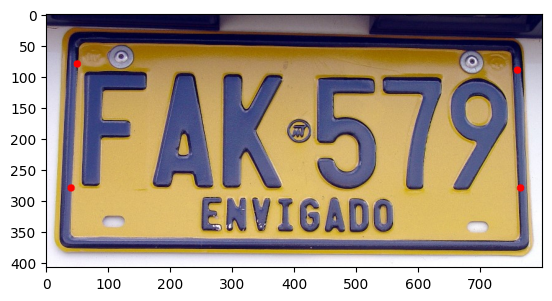

In [125]:
# Calculando puntos en la placa.
cv2.circle(image, (50, 80), radius=2, color=[255,0,0], thickness=7)
cv2.circle(image, (760, 90), radius=2, color=[255,0,0], thickness=7)
cv2.circle(image, (40, 280), radius=2, color=[255,0,0], thickness=7)
cv2.circle(image, (765, 280), radius=2, color=[255,0,0], thickness=7)
plt.imshow(image)

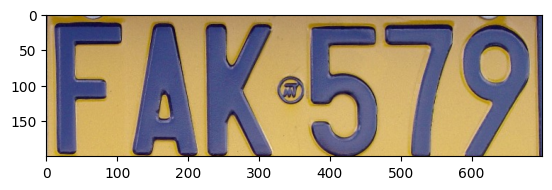

In [164]:
# Recortando placa numero uno con los puntos obtenidos.
points = [[50,80], [760,90], [40,280], [765,280]]
image1 = adjust_perspective(image, points)
plt.imshow(image1)

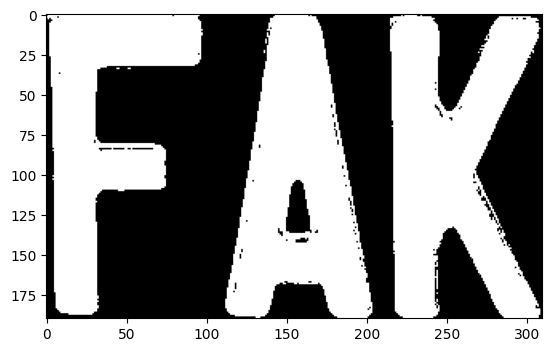

In [228]:
# Cambiamos la imagen a escala de grises.
image1_gray_left = cv2.cvtColor(image1[10:, 10:320], cv2.COLOR_RGB2GRAY)
image1_gray_right = cv2.cvtColor(image1[5:, 370:-10], cv2.COLOR_RGB2GRAY)

# Aplicamos un umbral para binarizar las imagenes.
# image1_thresh_left = cv2.adaptiveThreshold(image1_gray_left, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,97,2)
# image1_thresh_right = cv2.adaptiveThreshold(image1_gray_right, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,97,2)
image1_thresh_left = cv2.threshold(image1_gray_left, 125, 255, cv2.THRESH_BINARY_INV)[1]
image1_thresh_right = cv2.threshold(image1_gray_right, 125, 255, cv2.THRESH_BINARY_INV)[1]

plt.imshow(image1_thresh_left, cmap='gray')

In [229]:
kernel = np.ones((5,5), np.uint8)
image1_thresh_left_close = cv2.morphologyEx(image1_thresh_left, cv2.MORPH_CLOSE, kernel)
image1_thresh_right_close = cv2.morphologyEx(image1_thresh_right, cv2.MORPH_CLOSE, kernel)

[]

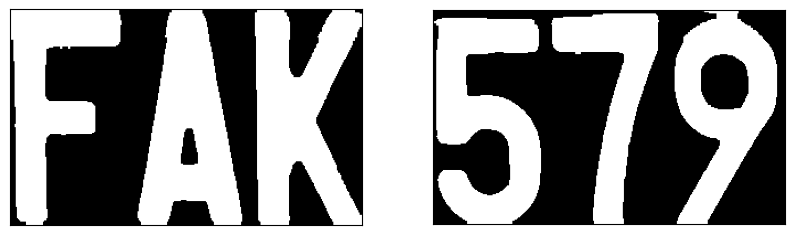

In [230]:
# Plot de las imagenes.
fig, axe = plt.subplots(1, 2, figsize=(10, 5))
axe[0].imshow(image1_thresh_left_close, cmap='gray')
axe[0].set_xticks([])
axe[0].set_yticks([])
axe[1].imshow(image1_thresh_right_close, cmap='gray')
axe[1].set_yticks([])
axe[1].set_xticks([])

In [251]:
# BLOQUE DE CODIGO DONDE SE SACAN LOS CONTORNOS DE LAS IMAGENES.

# Sacamos contornos.
# Buscar contornos en la imagen binarizada.
contours, _ = cv2.findContours(image1_thresh_left_close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
letters = []
# Recorrer los contornos encontrados
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    letter = image1_thresh_left_close[y:y+h, x:x+w]
    # Se va a aplicar a cada image...
    letter = cv2.resize(letter, [75, 150]) # Imagen de 75*150
    letter = cv2.threshold(letter, 125, 255, cv2.THRESH_BINARY)[1] # Binarización con umbral de 125.
    letter = letter / 255 # Normalizando.
    letters.append(letter)

# Sacamos contornos.
# Buscar contornos en la imagen binarizada.
contours, _ = cv2.findContours(image1_thresh_right_close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
numbers = []
# Recorrer los contornos encontrados
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    number = image1_thresh_right_close[y:y+h, x:x+w]
    # Se va a aplicar a cada image...
    number = cv2.resize(number, [75, 150]) # Imagen de 75*150
    number = cv2.threshold(number, 125, 255, cv2.THRESH_BINARY)[1] # Binarización con umbral de 125.
    number = number / 255 # Normalizando.
    numbers.append(number)

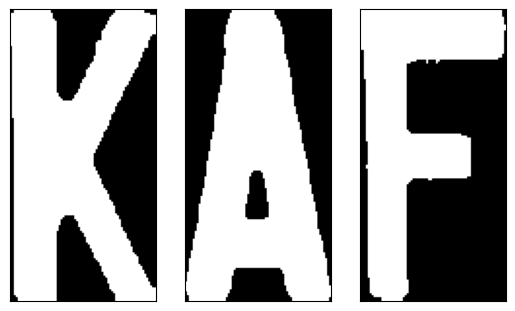

In [252]:
plot_all(letters, size=(1,3))

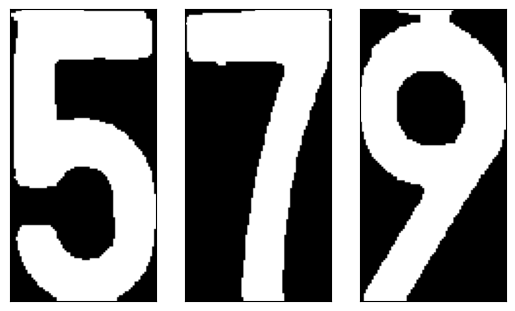

In [253]:
plot_all(numbers, size=(1,3))

In [279]:
# Aplanando las imagenes para pasarlas a la red neuronal.
letters_flatten = []
for letter in letters:
    letters_flatten.append(letter.reshape(75*150))
letters_flatten = pd.DataFrame(letters_flatten)

numbers_flatten = []
for number in numbers:
    numbers_flatten.append(number.reshape(75*150))
numbers_flatten = pd.DataFrame(numbers_flatten)

# Prediciendo la placa 1

Prediciendo las letras y numeros

In [297]:
prediction_letters = ann_letters.predict(letters_flatten)
predict_numbers = ann_numbers.predict(numbers_flatten)

1/1 [==============================] - 0s 30ms/step


K A F
5 7 9


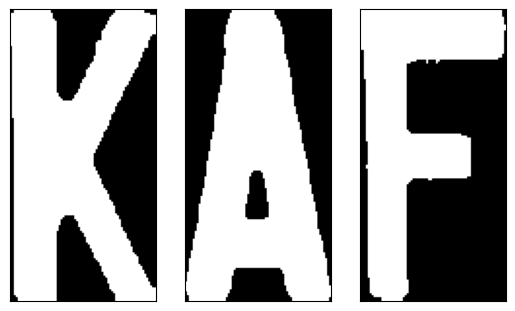

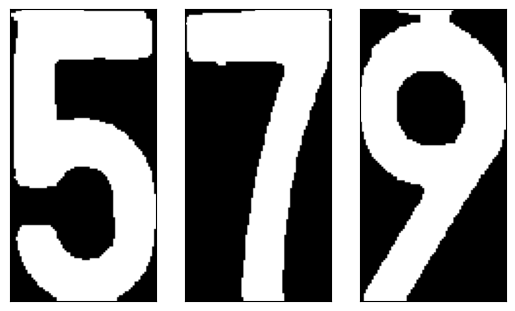

In [302]:
plot_all(letters, size=(1,3))
plot_all(numbers, size=(1,3))

targets = ['a','b','c','d','e','f','g','h','i','j','k','l','n','m','o','p','q','r','s','t','u','v','w','x','y','z']

# Imprimiendo en consola la prediccion de las letras.
print(targets[np.argmax(prediction_letters[0])].upper(), 
      targets[np.argmax(prediction_letters[1])].upper(), 
      targets[np.argmax(prediction_letters[2])].upper())
# Imprimiendo en consola la predicción de los numeros.
print(np.argmax(predict_numbers[0]), np.argmax(predict_numbers[1]), np.argmax(predict_numbers[2]))

# Procesando y probando placa 2.
Placa 2

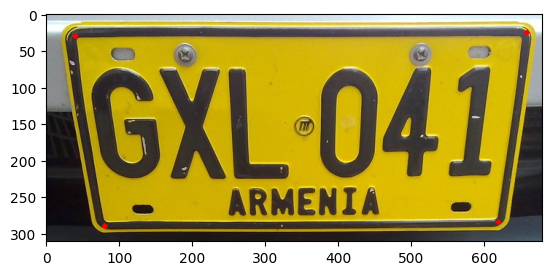

In [26]:
plate = path + '/' + plates[2]
image = cv2.imread(plate)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Calculando puntos en la placa.
cv2.circle(image, (40, 30), radius=2, color=[255,0,0], thickness=3)
cv2.circle(image, (659, 25), radius=2, color=[255,0,0], thickness=3)
cv2.circle(image, (80, 290), radius=2, color=[255,0,0], thickness=3)
cv2.circle(image, (620, 285), radius=2, color=[255,0,0], thickness=3)
plt.imshow(image)

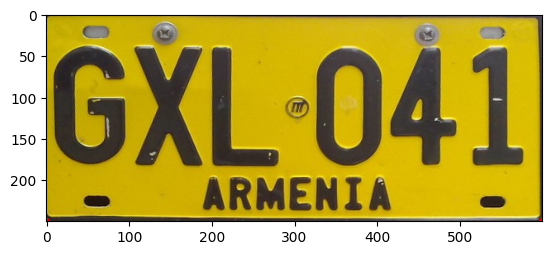

In [30]:
points = [[40, 30],[659,25],[80,290],[620,285]]
image_adjust = adjust_perspective(image, po=points, mask_width=600, mask_height=250)
plt.imshow(image_adjust)

In [49]:
# Regionamos la placa y separamos numeros y letras.
plate_letters = image_adjust[35:185,:290,:]
plate_numbers = image_adjust[35:185,320:-15,:]

In [50]:
# Convertimos a escala de grises.
plate_letters = cv2.cvtColor(plate_letters, cv2.COLOR_RGB2GRAY)
plate_numbers = cv2.cvtColor(plate_numbers, cv2.COLOR_RGB2GRAY)

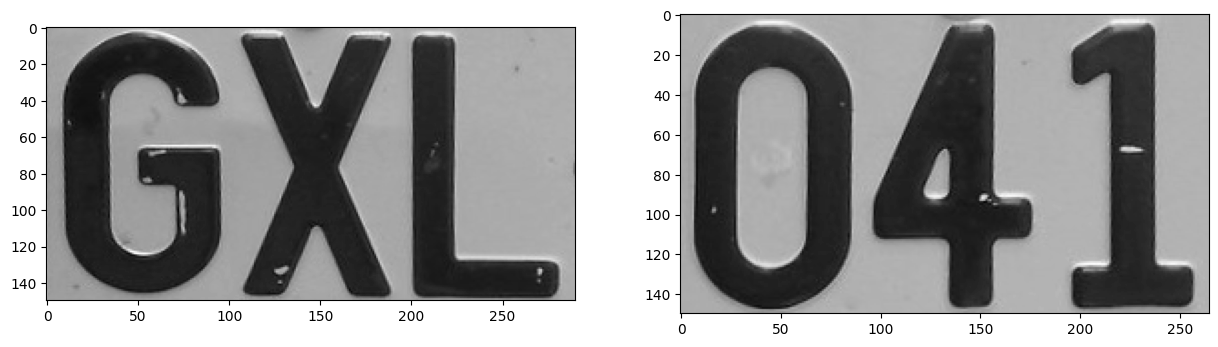

In [60]:
# Imprimimos resultados.
fig, axe = plt.subplots(1, 2, figsize=(15,5))
axe[0].imshow(plate_letters, cmap='gray')
axe[1].imshow(plate_numbers, cmap='gray')

In [55]:
# Binarizamos las imagenes para que esten en un rango de maximos y minimos de intencidad 0 y 255.
plate_letters_thresh = cv2.threshold(plate_letters, 125, 255, cv2.THRESH_BINARY_INV)[1]
plate_numbers_thresh = cv2.threshold(plate_numbers, 125, 255, cv2.THRESH_BINARY_INV)[1]

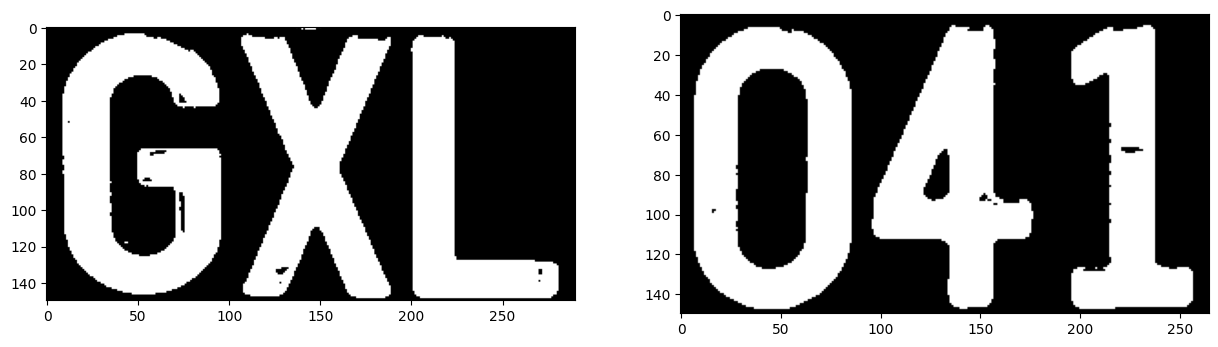

In [61]:
# Imprimimos resultados.
fig, axe = plt.subplots(1, 2, figsize=(15,5))
axe[0].imshow(plate_letters_thresh, cmap='gray')
axe[1].imshow(plate_numbers_thresh, cmap='gray')

In [73]:
# Aplicamos algoritmo morfologico de cierre para rellenar la figura.
kernel = np.ones((5,5), np.uint8)
# Cierre. Para reducir los espacios en blanco dentro de la letra y numeros.
plate_letters_thresh_closed = cv2.morphologyEx(plate_letters_thresh, cv2.MORPH_CLOSE, kernel)
plate_numbers_thresh_closed = cv2.morphologyEx(plate_numbers_thresh, cv2.MORPH_CLOSE, kernel)
# Apertura. Para reducir los puntos blancos o ruido fuera de las letras y numeros.
plate_letters_thresh_closed = cv2.morphologyEx(plate_letters_thresh_closed, cv2.MORPH_OPEN, kernel)
plate_numbers_thresh_closed = cv2.morphologyEx(plate_numbers_thresh_closed, cv2.MORPH_OPEN, kernel)

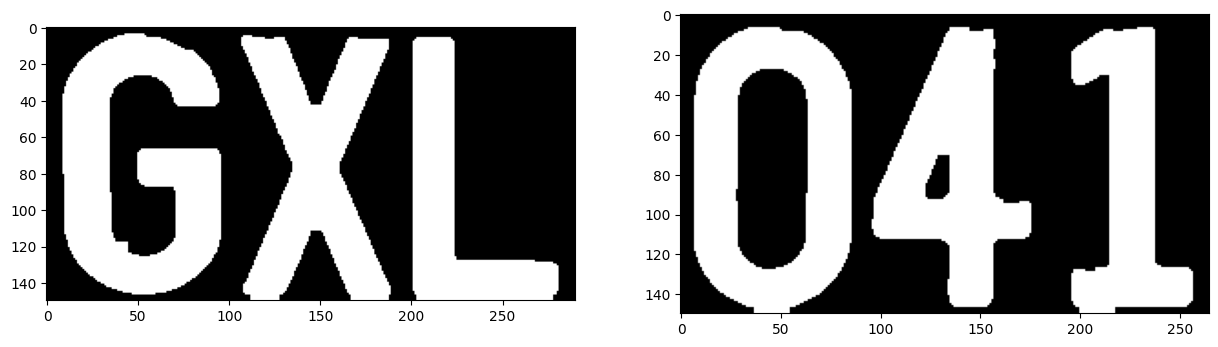

In [74]:
# Imprimimos resultados.
fig, axe = plt.subplots(1, 2, figsize=(15,5))
axe[0].imshow(plate_letters_thresh_closed, cmap='gray')
axe[1].imshow(plate_numbers_thresh_closed, cmap='gray')

In [88]:
db_letters, db_numbers = proccess_plate(plate_letters_thresh_closed, plate_numbers_thresh_closed)

In [107]:
prediction_letters = ann_letters.predict(db_letters)
predict_numbers = ann_numbers.predict(db_numbers)

1/1 [==============================] - 0s 62ms/step


L X G
1 4 0


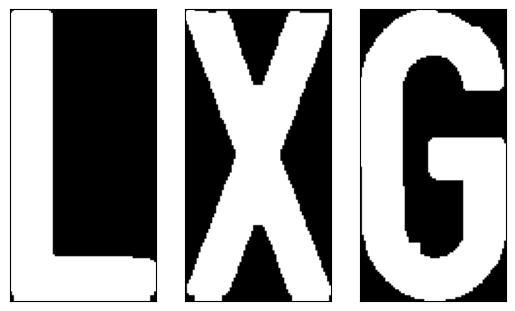

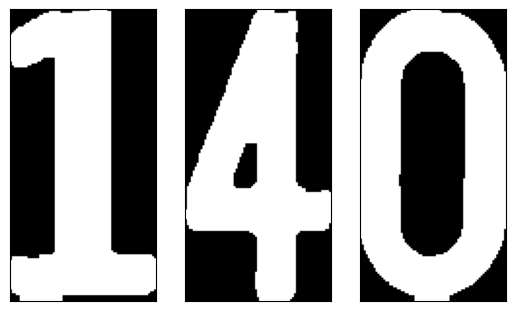

In [113]:
plot_all(get_contours(plate_letters_thresh_closed), size=(1, 3))
plot_all(get_contours(plate_numbers_thresh_closed), size=(1, 3))

targets = ['a','b','c','d','e','f','g','h','i','j','k','l','n','m','o','p','q','r','s','t','u','v','w','x','y','z']

# Imprimiendo en consola la prediccion de las letras.
print(targets[np.argmax(prediction_letters[0])].upper(), 
      targets[np.argmax(prediction_letters[1])].upper(), 
      targets[np.argmax(prediction_letters[2])].upper())
# Imprimiendo en consola la predicción de los numeros.
print(np.argmax(predict_numbers[0]), np.argmax(predict_numbers[1]), np.argmax(predict_numbers[2]))